## Notebook Para Transcrever Vídeos Do YouTube.<p>
Criação Daniel Dias da Comunidade Sandeco https://www.youtube.com/@canalsandeco<p>
Site: www.inarte.com.br<p>
Email: inarte@gmail.com <p>
<p>
LEIA COM ATENÇÃO
<p>
Como o uso da GPU T4 é gratuito, ele tem um limite de uso, portanto procure fazer pausas de 3 a 5 dias quando o limite for atingido e não estiver mais fazendo as transcrições.<p><p>
Não esqueça de fazer o donwload do seu arquivo quando terminar!<p><p>
Selecione uma instância com gpu t4 do lado direito superior (opções adicionais de conexão) antes de iniciar a execução dos códigos.<p>
Procure do lado direito superior a seta para baixo e altere o ambiente de execussão com GPU - T4.<p>

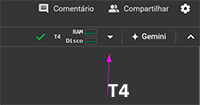


Instruções para Execução no Colab<p>
Execute cada bloco um a um aguarde cada bloco completar a execução completamente antes de passar para o próximo.<p>
Clique no botão "Iniciar Transcrição" para iniciar a transcrição e tradução do áudio no fim do último bloco.<p>
Procure o arquivo ao lado esquerdo na pasta onde ele foi salvo, e clique nos três pontos para realizar o download.<p>
Se deseja realizar mais de uma transcrição deve repetir todos os passos novamente.<p>
Pode começar suas transcrições!



In [ ]:
# Primeiramente, instale as dependências. Aguarde a instalação completa das dependências até o final da  instalação in formando que foi bem sucedida.
!pip install yt-dlp
!pip install git+https://github.com/openai/whisper.git
!pip install deep-translator langdetect tqdm numpy ipywidgets

print("Todas as Dependências Foram Instaladas com Sucesso!")
print("Pode Executar o Próximo Bloco de Código!")

In [ ]:
import subprocess
import whisper
import os
import torch
from deep_translator import GoogleTranslator
from langdetect import detect
import yt_dlp
from tqdm import tqdm
import numpy as np
import ipywidgets as widgets
from IPython.display import display

print("Bibliotecas importadas com sucesso! Pode Executar o Próximo Bloco de Código!")


Bibliotecas importadas com sucesso! Pode Executar o Próximo Bloco de Código!


In [ ]:
# Função para obter o título do vídeo e o nome do canal usando yt-dlp
def get_video_info(url):
    ydl_opts = {
        'quiet': True,
        'skip_download': True,
        'force_generic_extractor': True,
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(url, download=False)
        title = info.get('title', 'unknown_title')
        channel = info.get('uploader', 'unknown_channel')
        video_id = info.get('id', 'unknown_id')
        return title, channel, video_id

# Função para dividir o texto em partes menores
def split_text(text, max_length):
    words = text.split(' ')
    current_length = 0
    current_part = []
    parts = []

    for word in words:
        if current_length + len(word) + 1 > max_length:
            parts.append(' '.join(current_part))
            current_part = [word]
            current_length = len(word) + 1
        else:
            current_part.append(word)
            current_length += len(word) + 1

    if current_part:
        parts.append(' '.join(current_part))

    return parts

print("Pode Executar o Próximo Bloco de Código!")

Pode Executar o Próximo Bloco de Código!


Cole o link do Video após executar o próximo bloco de comando!

In [ ]:
# Solicita o link do vídeo ao usuário
video_url = input("Cole o link do vídeo e aperte Enter: ")

# Obtém o título, nome do canal e o ID do vídeo
video_title, channel_name, video_id = get_video_info(video_url)
print(f'Título do vídeo: {video_title}')
print(f'Nome do canal: {channel_name}')

# Monta a linha de comando como uma lista de argumentos
output_template = f"{video_id}.%(ext)s"
command = ['yt-dlp', '-x', '-f', 'bestaudio', '--audio-format', 'mp3', '-o', output_template, video_url]

# Executa a linha de comando para baixar o áudio
subprocess.run(command, check=True)

# Encontra o arquivo MP3 baixado
output_filename = None
for file in os.listdir('.'):
    if file.startswith(video_id) and file.endswith('.mp3'):
        output_filename = file
        break

if output_filename:
    # Renomeia o arquivo MP3 para incluir o título do vídeo e o nome do canal
    safe_video_title = "".join([c if c.isalnum() else "_" for c in video_title])
    safe_channel_name = "".join([c if c.isalnum() else "_" for c in channel_name])
    new_output_filename = f"{safe_channel_name}_{safe_video_title}.mp3"
    os.rename(output_filename, new_output_filename)
    output_filename = new_output_filename
    print(f"Arquivo MP3 baixado com sucesso! Ele foi renomeado para: {output_filename}")
    print("Pode Executar o Próximo Bloco de Código!")
else:
    print("Nenhum arquivo MP3 encontrado.")

Aguarde o terminio para executar o próximo codigo!

In [ ]:
# Caixa de seleção para escolher o modelo Whisper
print("Escolha o modelo que deseja usar e aguarde a mensagem de sucesso!:")
model_options = ['medium', 'large']
model_dropdown = widgets.Dropdown(options=model_options, value='medium', description='Modelo:')
display(model_dropdown)

# Botão para baixar o modelo
download_button = widgets.Button(description="Baixar Modelo")
download_output = widgets.Output()

display(download_button, download_output)

def download_model(b):
    with download_output:
        download_output.clear_output()
        model_choice = model_dropdown.value
        global model
        model = whisper.load_model(model_choice, device="cuda")
        print(f"Modelo {model_choice} baixado com sucesso.")

download_button.on_click(download_model)


In [ ]:
# Botão para iniciar a transcrição e tradução
transcribe_button = widgets.Button(description="Iniciar Transcrição")
transcribe_output = widgets.Output()

display(transcribe_button, transcribe_output)

def transcribe_audio(b):
    with transcribe_output:
        transcribe_output.clear_output()
        global model
        if output_filename:
            # Carrega o áudio
            audio = whisper.load_audio(output_filename)
            audio = whisper.pad_or_trim(audio)  # Pad or trim to fit model requirements
            mel = whisper.log_mel_spectrogram(audio).to(model.device)

            # Transcreve o áudio
            print("Transcrevendo áudio...")
            options = whisper.DecodingOptions(language="en")
            result = model.decode(mel, options)
            original_text = result.text.strip()
            print("Transcrição original salva.")

            # Detecta o idioma da transcrição
            detected_language = detect(original_text)
            print("Fazendo tradução...")

            # Define a língua de destino para a tradução
            target_language = 'pt' if detected_language == 'en' else 'en'

            # Dividir o texto em partes menores para tradução
            text_parts = split_text(original_text, 4999)
            translated_text = ""

            # Tradução para o idioma de destino
            translator = GoogleTranslator(source=detected_language, target=target_language)
            for part in text_parts:
                translated_text += translator.translate(part) + " "

            translated_text = translated_text.strip()

            # Cria o diretório "textos_transcritos" se não existir
            output_dir = "textos_transcritos"
            os.makedirs(output_dir, exist_ok=True)

            # Salva a transcrição em um arquivo com o nome do título do vídeo e do canal
            transcribed_filename = os.path.join(output_dir, f"{safe_channel_name}_{safe_video_title}.txt")
            with open(transcribed_filename, 'w', encoding='utf-8') as f:
                f.write(f"Transcrição original:\n{original_text}\n\n")
                f.write(f"Transcrição traduzida para {target_language}:\n{translated_text}\n")
            print(f"Trabalho completo. Transcrição salva em: {os.path.abspath(transcribed_filename)}")

            # Libera a memória da GPU
            del model
            torch.cuda.empty_cache()

transcribe_button.on_click(transcribe_audio)


Neste último bloco de código é onde é feito a transcrição e tradução do texto, isso leva um tempo tenha paciência!<p>
Um texto vai avisar quando estiver terminado!